<a href="https://colab.research.google.com/github/SmaranikaSethy/Air_Quality_Index_Project/blob/main/AQI_MODIFIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PRSA_DATA.zip to PRSA_DATA.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("PRSA_DATA.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

os.listdir("data")

['PRSA_DATA']

In [3]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

**Data Collection**

In [4]:
import glob
# Glob is used to seaarch file having same pattern here it is used to find all the files that has .csv in PRSA_DATA folder

files = glob.glob("data/PRSA_DATA/*.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (210384, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping


**Exploratort Data Analysis**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       210384 non-null  int64  
 1   year     210384 non-null  int64  
 2   month    210384 non-null  int64  
 3   day      210384 non-null  int64  
 4   hour     210384 non-null  int64  
 5   PM2.5    205894 non-null  float64
 6   PM10     207065 non-null  float64
 7   SO2      206447 non-null  float64
 8   NO2      204532 non-null  float64
 9   CO       198724 non-null  float64
 10  O3       204281 non-null  float64
 11  TEMP     210167 non-null  float64
 12  PRES     210174 non-null  float64
 13  DEWP     210167 non-null  float64
 14  RAIN     210179 non-null  float64
 15  wd       209705 non-null  object 
 16  WSPM     210214 non-null  float64
 17  station  210384 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 28.9+ MB


In [6]:
# Checking for the null values in the dataset
null_percentile=(data.isnull().sum() / len(data)) * 100
print(null_percentile)

No         0.000000
year       0.000000
month      0.000000
day        0.000000
hour       0.000000
PM2.5      2.134193
PM10       1.577591
SO2        1.871340
NO2        2.781580
CO         5.542247
O3         2.900886
TEMP       0.103145
PRES       0.099817
DEWP       0.103145
RAIN       0.097441
wd         0.322743
WSPM       0.080805
station    0.000000
dtype: float64


As in all columns the null Value % is very small so we will not drop the null values and fill all columns with median values except the 'wd' column as it is categorical so we will fill it with mode value.

In [7]:
numeric_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

for col in numeric_cols:
    data[col].fillna(data[col].median())

data['wd'].fillna(data['wd'].mode()[0])

# droping the index column to make the data more clearer
data = data.drop(columns=['No'])

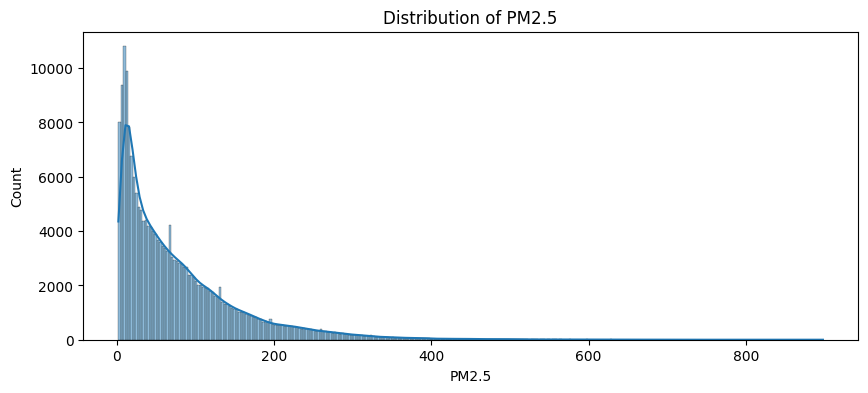

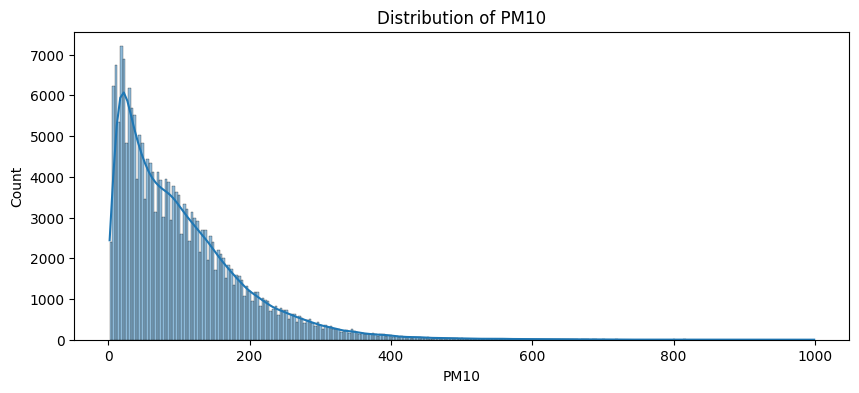

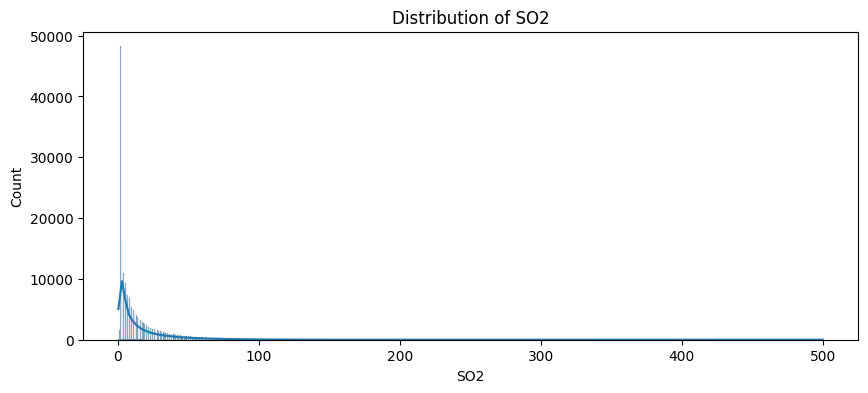

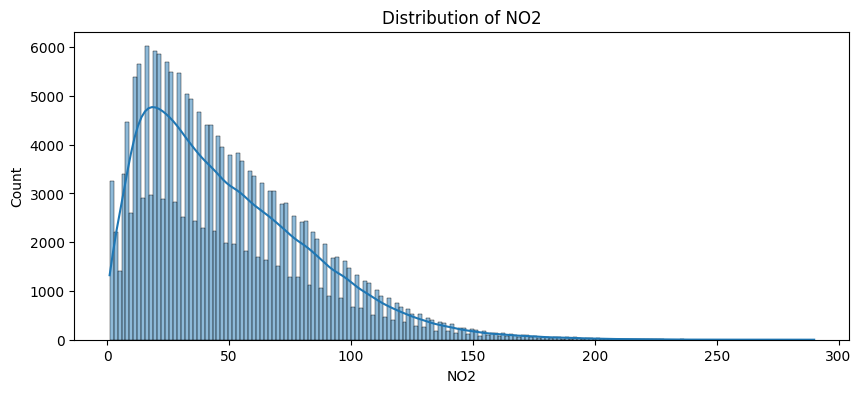

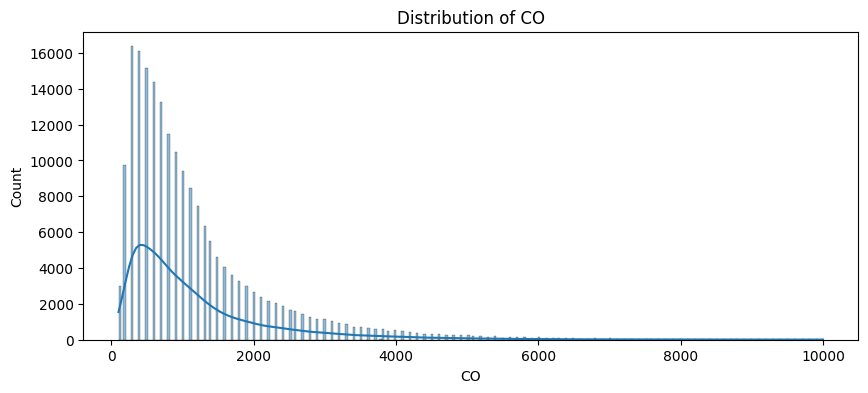

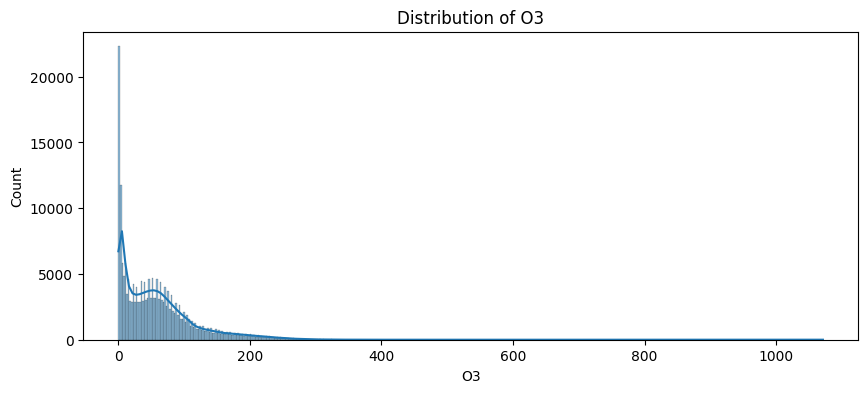

In [8]:
pollutants = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]

for col in pollutants:
    plt.figure(figsize=(10,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

This shows that all the Pollutant distributions are right-skewed.
Hence, most of the days pollution is moderate or low.

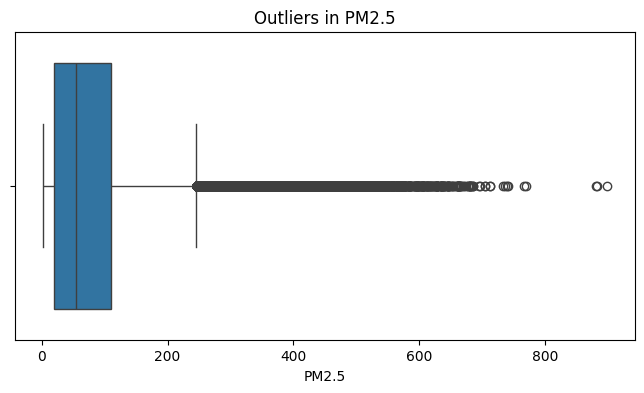

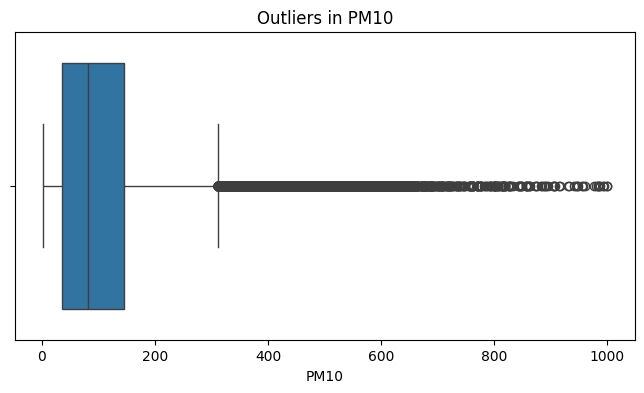

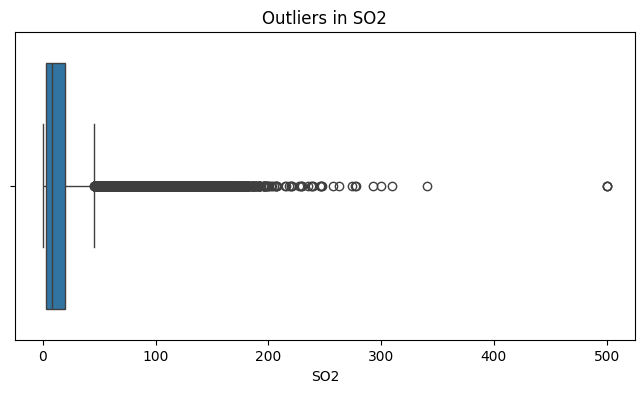

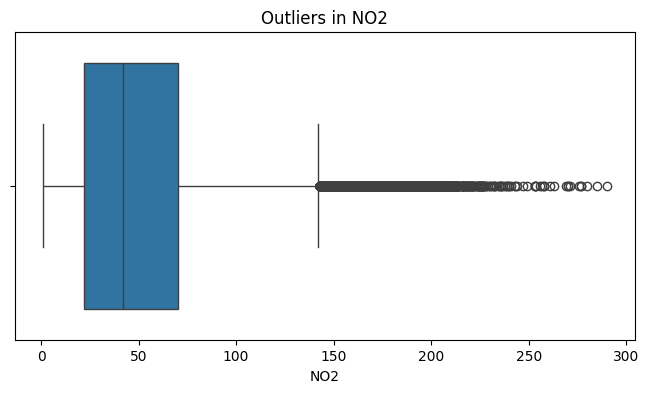

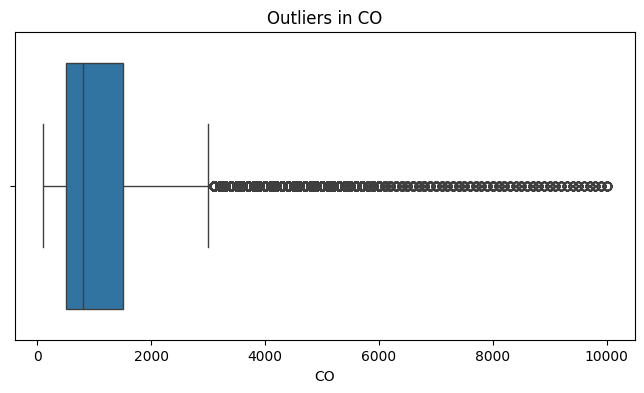

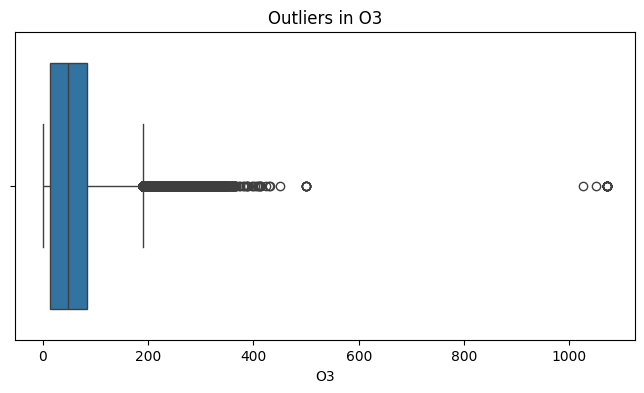

In [9]:
# Checking for outliers
for col in pollutants:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=data[col])
    plt.title(f"Outliers in {col}")
    plt.show()


Here we are going to keep the outliers as they shows real air pollution episodes
we do not need to transform outliers as the Random forest and XGBoost are tree-based algorithms and they are naturally resistant to outliers.

**Feature Engineering**

In [10]:
#converting to datetime format
data['date'] = pd.to_datetime(
    data[['year','month','day','hour']]
)

print("Datetime column created!")
print(data.head())

#converting Pollutants columns to neumeric
pollutants = ['PM2.5','PM10','SO2','NO2','CO','O3']

for col in pollutants:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#Converting weather columns to numeric
weather_cols = ['TEMP','PRES','DEWP','RAIN','WSPM']

for col in weather_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

#Converting categorical columns
data['wd'] = data['wd'].astype('category')
data['station'] = data['station'].astype('category')

Datetime column created!
   year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    3.0   6.0  13.0   7.0  300.0  85.0  -2.3  1020.8   
1  2013      3    1     1    3.0   3.0   6.0   6.0  300.0  85.0  -2.5  1021.3   
2  2013      3    1     2    3.0   3.0  22.0  13.0  400.0  74.0  -3.0  1021.3   
3  2013      3    1     3    3.0   6.0  12.0   8.0  300.0  81.0  -3.6  1021.8   
4  2013      3    1     4    3.0   3.0  14.0   8.0  300.0  81.0  -3.5  1022.3   

   DEWP  RAIN   wd  WSPM    station                date  
0 -19.7   0.0    E   0.5  Changping 2013-03-01 00:00:00  
1 -19.0   0.0  ENE   0.7  Changping 2013-03-01 01:00:00  
2 -19.9   0.0  ENE   0.2  Changping 2013-03-01 02:00:00  
3 -19.1   0.0  NNE   1.0  Changping 2013-03-01 03:00:00  
4 -19.4   0.0    N   2.1  Changping 2013-03-01 04:00:00  


**AQI Calculations**

In [11]:
# taking PM2.5 to convert into AQL Labels
def aqi_category(pm25):
    if pm25 <= 50:
      return "Good"
    elif pm25 <= 100:
       return "Moderate"
    elif pm25 <= 200:
      return "Unhealthy"
    else:
      return "Severe"

data["AQI_label"] = data["PM2.5"].apply(aqi_category)

# mapping of PM2.5 → AQI
def compute_aqi_pm25(pm):
    if pm <= 50:
        return pm                     # 0–50
    elif pm <= 100:
        return 50 + (pm - 50)         # 51–100
    elif pm <= 200:
        return 100 + (pm - 100)       # 101–200
    else:
        return 200 + (pm - 200)       # >200

# Create numeric AQI column
data["AQI_PM25"] = data["PM2.5"].apply(compute_aqi_pm25)


print("\nAQI Categories:")
print(data["AQI_label"].value_counts())

print("\nSample AQI_PM25 values:")
print(data[["PM2.5", "AQI_PM25", "AQI_label"]].head())


AQI Categories:
AQI_label
Good         98797
Moderate     49280
Unhealthy    40963
Severe       21344
Name: count, dtype: int64

Sample AQI_PM25 values:
   PM2.5  AQI_PM25 AQI_label
0    3.0       3.0      Good
1    3.0       3.0      Good
2    3.0       3.0      Good
3    3.0       3.0      Good
4    3.0       3.0      Good


In [23]:
# Ensure sorted chronologically
data = data.sort_values("date")

# Create time features
data["hour"] = data["date"].dt.hour
data["day"] = data["date"].dt.day
data["month"] = data["date"].dt.month
data["weekday"] = data["date"].dt.weekday

# Pollutant list
pollutants = ['PM2.5','PM10','SO2','NO2','CO','O3']

# Lag + rolling average
for col in pollutants:
    data[f"{col}_lag1"] = data[col].shift(1)          # 1-hour lag
    data[f"{col}_roll3"] = data[col].rolling(3).mean() # 3-hour rolling average

# Remove rows with NaN due to lag/rolling
data = data.dropna().reset_index(drop=True)


In [24]:
data.columns

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'date',
       'AQI_label', 'AQI_PM25', 'AQI_label_enc', 'weekday', 'PM2.5_lag1',
       'PM2.5_roll3', 'PM10_lag1', 'PM10_roll3', 'SO2_lag1', 'SO2_roll3',
       'NO2_lag1', 'NO2_roll3', 'CO_lag1', 'CO_roll3', 'O3_lag1', 'O3_roll3'],
      dtype='object')

In [25]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
data["wd"] = le1.fit_transform(data["wd"])
data["station"] = le2.fit_transform(data["station"])
data["AQI_label_enc"] = le3.fit_transform(data["AQI_label"])

In [34]:
features = [
    'PM2.5','PM10','SO2','NO2','CO','O3',

    # Lag & rolling features
    'PM2.5_lag1','PM2.5_roll3',
    'PM10_lag1','PM10_roll3',
    'SO2_lag1','SO2_roll3',
    'NO2_lag1','NO2_roll3',
    'CO_lag1','CO_roll3',
    'O3_lag1','O3_roll3',

    # Meteorological
    'TEMP','PRES','DEWP','RAIN','WSPM',

    # Time features
    'hour','day','month','weekday',

    # Categorical (encoded)
    'wd','station'
]
# --- REMOVE PM2.5 leakage ---
remove_leakage = ['PM2.5', 'PM2.5_lag1', 'PM2.5_roll3']

features = [f for f in features if f not in remove_leakage]

X = data[features]
y = data["AQI_label_enc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [35]:
# Scaling for normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
#using Random forest Classifier
rf = RandomForestClassifier(
     n_estimators=150,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    random_state=42
)
rf.fit(X_train_scaled, y_train)

rf_pred = rf.predict(X_test_scaled)

#using XGBoost classifier
xgb = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=10,
    reg_lambda=15,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train_scaled, y_train)

xgb_pred = xgb.predict(X_test_scaled)


In [37]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest F1:", f1_score(y_test, rf_pred, average='macro'))

print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost F1:", f1_score(y_test, xgb_pred, average='macro'))

print("\nRF Report:\n", classification_report(y_test, rf_pred))
print("\nXGB Report:\n", classification_report(y_test, xgb_pred))

Random Forest Accuracy: 0.8474728970839965
Random Forest F1: 0.8270100006739846

XGBoost Accuracy: 0.842187453076669
XGBoost F1: 0.8233571342447924

RF Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     16040
           1       0.73      0.75      0.74      7965
           2       0.87      0.85      0.86      2718
           3       0.77      0.80      0.78      6576

    accuracy                           0.85     33299
   macro avg       0.83      0.83      0.83     33299
weighted avg       0.85      0.85      0.85     33299


XGB Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     16040
           1       0.72      0.72      0.72      7965
           2       0.85      0.89      0.87      2718
           3       0.77      0.80      0.78      6576

    accuracy                           0.84     33299
   macro avg       0.82      0.83      0.82     33299
weighted a